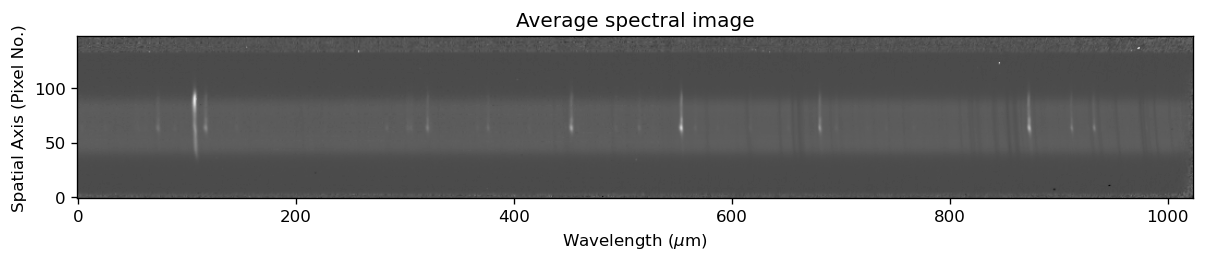

In [22]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 140
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model

import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []

start_nirspec7 = 22 # fits index start, min >= 1, max <= n
end_nirspec7 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + start_nirspec7
    if n>= start_nirspec7 and n < 10:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s000' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < end_nirspec7: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= end_nirspec7:
        break
nirspec7_data_array = np.array(nirspec7_data)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-start_nirspec7], 
                              nirspec7_data_array[33-start_nirspec7], 
                              nirspec7_data_array[34-start_nirspec7], 
                              nirspec7_data_array[35-start_nirspec7], 
                              nirspec7_data_array[36-start_nirspec7], 
                              nirspec7_data_array[37-start_nirspec7], 
                              nirspec7_data_array[38-start_nirspec7], 
                              nirspec7_data_array[39-start_nirspec7], 
                              nirspec7_data_array[40-start_nirspec7], 
                              nirspec7_data_array[41-start_nirspec7],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-start_nirspec7], 
                                 nirspec7_data_array[23-start_nirspec7], 
                                 nirspec7_data_array[24-start_nirspec7],
                                 nirspec7_data_array[25-start_nirspec7], 
                                 nirspec7_data_array[26-start_nirspec7], 
                                 nirspec7_data_array[27-start_nirspec7], 
                                 nirspec7_data_array[28-start_nirspec7], 
                                 nirspec7_data_array[29-start_nirspec7], 
                                 nirspec7_data_array[30-start_nirspec7], 
                                 nirspec7_data_array[31-start_nirspec7],), axis=0)

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec7 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec7:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec7:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec7_data_array[fn_sky1-start_nirspec7]
    sky2 = nirspec7_data_array[fn_sky2-start_nirspec7]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

fn_spec = 61 # frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
sky_subtracted = (nirspec7_data_array[fn_spec-start_nirspec7] - sky_total) / (average_flat_field - average_flat_lamp_off)
#sky_subtracted[sky_subtracted>0.2] = 0.2
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
plt.figure(figsize=(12,2))
plt.imshow(sky_subtracted, cmap='gist_gray')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Spatial Axis (Pixel No.)')
plt.title('Average spectral image')
plt.gca().invert_yaxis()
#plt.xlim(2.12,2.122)
#plt.ylim(120,30)
#plt.colorbar(orientation='horizontal', pad=0.1)
#plt.savefig('spec_img', bbox_inches='tight')

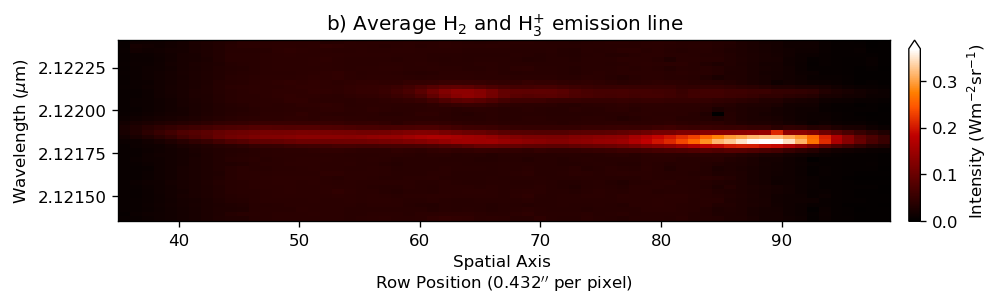

In [23]:
a = np.delete(sky_subtracted, np.s_[200:], 1)
b = np.delete(a, np.s_[:90], 1)
c = np.delete(b, np.s_[40:], 1)
d = np.delete(c, np.s_[100:], 0)
e = np.delete(d, np.s_[:35], 0)


plt.figure(figsize=(10,2))
plt.imshow(e.T, aspect='auto', extent=[35, 99, waverange[129], waverange[90]], cmap='gist_heat')
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel(r'Wavelength ($\mu$m)')
plt.ticklabel_format(useOffset=False)
plt.title(r'b) Average H$_2$ and H$_3^{+}$ emission line')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Intensity (Wm$^{-2}$sr$^{-1}$)')
plt.savefig('poster/spec_img', bbox_inches='tight', dpi=1000)

In [4]:
# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# confirm start and end frame number
fn_start = 60
fn_end = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

# create empty list to collect result
h2_a0_map = []
h2_a1_map = []
h2_a2_map = []


print('H2 LOOP START')
print()
# scan selected range of frames
for fn in range(fn_start, fn_end):
    # check if selected frame is a sky frame
    if fn in sky_frame:
        print('Frame Number = ' + str(fn) + '(Sky Frame)')
        print()
        continue
    # perform sky subtraction
    skyfinal = scale_sky_frame(fn)
    sky_subtract = (nirspec7_data_array[fn-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    # select waverange for gaussian fit
    a = np.delete(sky_subtract, np.s_[200:1024], 1)
    b = np.delete(a, np.s_[:85], 1)
    c = np.delete(b, np.s_[35:], 1)
    
    # define new wavlength axis
    pixel = np.linspace(0, np.size(c, 1), np.size(c, 1))
    
    # partition frame numbers to account for change in spatial axis
    if fn >= 86 and fn < fn_end:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 127
        lower_h2 = 37

        h2_a0 = np.zeros(upper_h2 - lower_h2)
        h2_a1 = np.zeros(upper_h2 - lower_h2)
        h2_a2 = np.zeros(upper_h2 - lower_h2)
        
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            if i >= 103 and i < upper_h2:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.03)
                h2_params.add('a1', value=10)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                
            if i >= 90 and i < 103:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.04)
                h2_params.add('a1', value=12)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                
            if i >= 84 and i < 90:
                h2_model = Model(gaussian_fit)

                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.05)
                h2_params.add('a1', value=12)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
        
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
        
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
    
            if i >= 60 and i < 84:
                h2_model = Model(gaussian_fit)

                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.02)
                h2_params.add('a1', value=14)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
        
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
        
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
    
            if i >= lower_h2 and i < 60:
                h2_model = Model(gaussian_fit)

                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.02)
                h2_params.add('a1', value=17)
                h2_params.add('a2', value=2.5)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
        
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
        
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

    
    # partition frame numbers to account for change in spatial axis
    if fn >= 84 and fn < 86:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 130
        lower_h2 = 40

        h2_a0 = np.zeros(upper_h2 - lower_h2)
        h2_a1 = np.zeros(upper_h2 - lower_h2)
        h2_a2 = np.zeros(upper_h2 - lower_h2)
        
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            if i >= 125 and i < upper_h2:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.05)
                h2_params.add('a1', value=8)
                h2_params.add('a2', value=3)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 115 and i < 125:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.2)
                h2_params.add('a1', value=9)
                h2_params.add('a2', value=3)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 100 and i < 115:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.1)
                h2_params.add('a1', value=11)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 84 and i < 100:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.1)
                h2_params.add('a1', value=12)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 70 and i < 84:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.08)
                h2_params.add('a1', value=15)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 60 and i < 70:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.1)
                h2_params.add('a1', value=15)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
               
            if i >= 50 and i < 60:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.08)
                h2_params.add('a1', value=16)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                
            if i >= lower_h2 and i < 50:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.02)
                h2_params.add('a1', value=18)
                h2_params.add('a2', value=2.5)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                

    # partition frame numbers to account for change in spatial axis
    if fn >= 80 and fn < 84:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 130
        lower_h2 = 40

        h2_a0 = np.zeros(upper_h2 - lower_h2)
        h2_a1 = np.zeros(upper_h2 - lower_h2)
        h2_a2 = np.zeros(upper_h2 - lower_h2)
        
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            if i >= 125 and i < upper_h2:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.05)
                h2_params.add('a1', value=8)
                h2_params.add('a2', value=3)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                
            if i >= 115 and i < 125:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.1)
                h2_params.add('a1', value=9)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 100 and i < 115:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.1)
                h2_params.add('a1', value=11)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                
            if i >= 84 and i < 100:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.1)
                h2_params.add('a1', value=12)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 70 and i < 84:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.08)
                h2_params.add('a1', value=14)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 60 and i < 70:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.1)
                h2_params.add('a1', value=15)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
               
            if i >= 50 and i < 60:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.08)
                h2_params.add('a1', value=16)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                
            if i >= lower_h2 and i < 50:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.02)
                h2_params.add('a1', value=18)
                h2_params.add('a2', value=2.5)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                
                
    # partition frame numbers to account for change in spatial axis
    if fn >= 70 and fn < 80:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 97
        lower_h2 = 7

        h2_a0 = np.zeros(upper_h2 - lower_h2)
        h2_a1 = np.zeros(upper_h2 - lower_h2)
        h2_a2 = np.zeros(upper_h2 - lower_h2)
        
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            if i >= 87 and i < upper_h2:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.01)
                h2_params.add('a1', value=10)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 67 and i < 87:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.08)
                h2_params.add('a1', value=13)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 47 and i < 67:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.1)
                h2_params.add('a1', value=15)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 27 and i < 47:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.05)
                h2_params.add('a1', value=16)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                
            if i >= lower_h2 and i < 27:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.01)
                h2_params.add('a1', value=19)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                

    # partition frame numbers to account for change in spatial axis
    if fn >= fn_start and fn < 70:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 100
        lower_h2 = 10

        h2_a0 = np.zeros(upper_h2 - lower_h2)
        h2_a1 = np.zeros(upper_h2 - lower_h2)
        h2_a2 = np.zeros(upper_h2 - lower_h2)
        
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            if i >= 90 and i < upper_h2:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.01)
                h2_params.add('a1', value=11)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 70 and i < 90:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.08)
                h2_params.add('a1', value=13)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 50 and i < 70:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.1)
                h2_params.add('a1', value=15)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value

            if i >= 30 and i < 50:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.05)
                h2_params.add('a1', value=16)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                
            if i >= lower_h2 and i < 30:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.02)
                h2_params.add('a1', value=19)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                h2_a0[i-lower_h2] = h2_fit_result.params['a0'].value
                h2_a1[i-lower_h2] = h2_fit_result.params['a1'].value
                h2_a2[i-lower_h2] = h2_fit_result.params['a2'].value
                
    print()
    
    # Collect fitting parameters of each frame number   
    h2_a0_map.append(h2_a0)
    h2_a1_map.append(h2_a1)
    h2_a2_map.append(h2_a2)
    
print('DONE')

H2 LOOP START

Frame Number = 60(Sky Frame)

Frame Number = 61
ValueError occured at i=30
ValueError occured at i=99

Frame Number = 62
ValueError occured at i=13
ValueError occured at i=17
ValueError occured at i=19

Frame Number = 63
ValueError occured at i=99

Frame Number = 64
ValueError occured at i=11
ValueError occured at i=12
ValueError occured at i=99

Frame Number = 65
ValueError occured at i=20
ValueError occured at i=88
ValueError occured at i=97

Frame Number = 66
ValueError occured at i=11
ValueError occured at i=14
ValueError occured at i=20

Frame Number = 67
ValueError occured at i=10
ValueError occured at i=18
ValueError occured at i=95

Frame Number = 68
ValueError occured at i=19
ValueError occured at i=94

Frame Number = 69

Frame Number = 70
ValueError occured at i=9
ValueError occured at i=27

Frame Number = 71
ValueError occured at i=7

Frame Number = 72(Sky Frame)

Frame Number = 73
ValueError occured at i=56
ValueError occured at i=93
ValueError occured at i=9

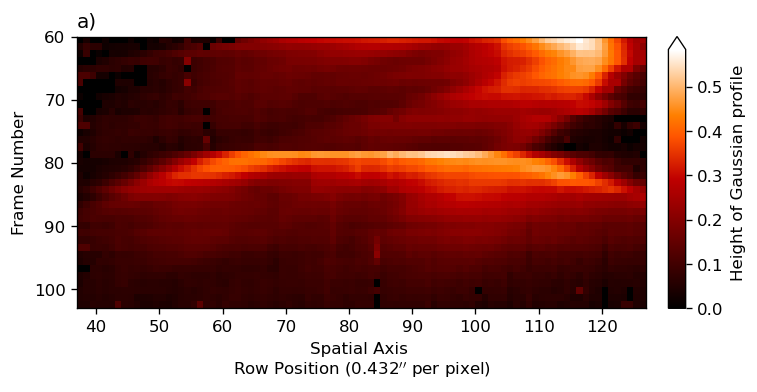

In [6]:
h2a0 = np.vstack(h2_a0_map)
h2a0[h2a0>0.5] = 0
#h2a0[np.where(h2a0>0.05)] = np.mean(np.mean(h2a0,axis=1))
h2a0[h2a0<0] = 0

plt.figure(figsize=(12,3))
plt.imshow(np.sqrt(h2a0), extent=[lower_h2, upper_h2, fn_end, fn_start], cmap='gist_heat')
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title('a)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Height of Gaussian profile')
#plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Intensity (Wm$^{-2}$sr$^{-1}$)')
plt.savefig('poster/a0map_h2', bbox_inches='tight')

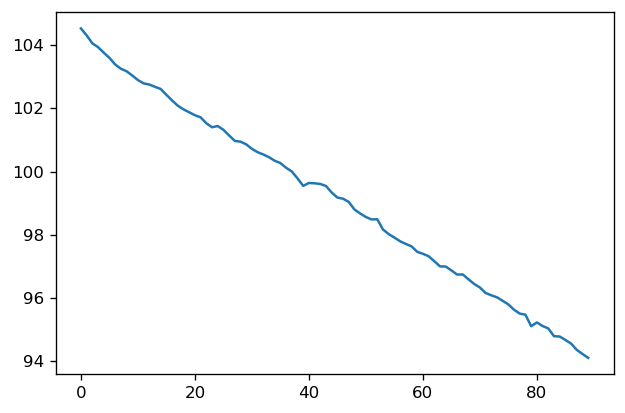

In [10]:
plt.plot(h2a1[24])

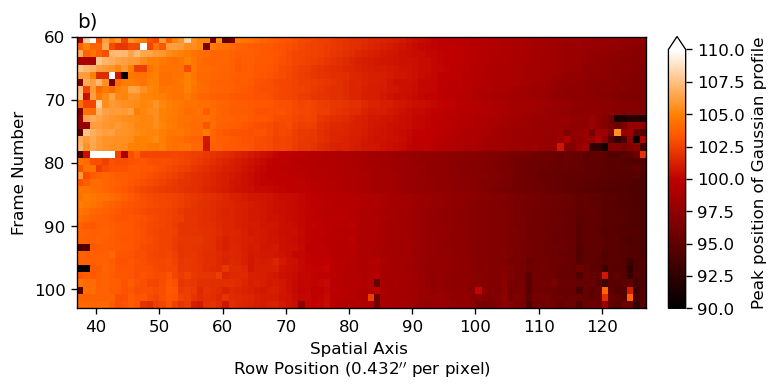

In [9]:
h2a1 = np.vstack(h2_a1_map) + 86
h2a1[h2a1<90] = 90
h2a1[h2a1>110] = 110

plt.figure(figsize=(12,3))
plt.imshow(h2a1, extent=[lower_h2, upper_h2, fn_end, fn_start], cmap='gist_heat')
#plt.imshow(h2a1-(np.sum(h2a1, axis=0)/len(h2a1)), extent=[lower_h2, upper_h2, fn_start, fn_end], cmap='gist_heat')
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title('b)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Peak position of Gaussian profile')
#plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'LOS Velocity (km s$^{-1}$')
plt.savefig('poster/a1map_h2', bbox_inches='tight')

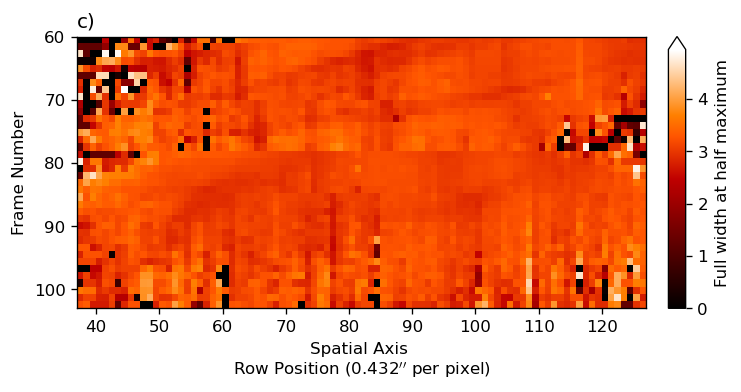

In [181]:
h2a2 = np.vstack(h2_a2_map)
h2a2[h2a2>2.1] = 0
h2a2[h2a2<0] = 0

plt.figure(figsize=(12,3))
plt.imshow(h2a2*np.sqrt(2*np.log(2))*2, extent=[lower_h2, upper_h2, fn_end, fn_start], cmap='gist_heat')
plt.xlabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.ylabel('Frame Number')
plt.title('c)', loc='left')
plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Full width at half maximum')
plt.savefig('poster/a2map_h2', bbox_inches='tight')

# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# confirm start and end frame number
fn_start = 70
fn_end = 103
sky_frame = (51, 59, 60, 72, 78, 79, 91, 103)

# create empty list to collect result
h2_a0_map = []
h2_a1_map = []
h2_a2_map = []


print('H2 LOOP START')
print()
# scan selected range of frames
for fn in range(fn_start, fn_end):
    # check if selected frame is a sky frame
    if fn in sky_frame:
        print('Frame Number = ' + str(fn) + '(Sky Frame)')
        print()
        continue
    # perform sky subtraction
    skyfinal = scale_sky_frame(fn)
    sky_subtract = (nirspec7_data_array[fn-start_nirspec7] - skyfinal) / (average_flat_field - average_flat_lamp_off)
    
    # select waverange for gaussian fit
    a = np.delete(sky_subtract, np.s_[200:1024], 1)
    b = np.delete(a, np.s_[:85], 1)
    c = np.delete(b, np.s_[35:], 1)
    
    # define new wavlength axis
    pixel = np.linspace(0, np.size(c, 1), np.size(c, 1))
    
    # partition frame numbers to account for change in spatial axis
    if fn >= fn_start and fn < fn_end:
        print('Frame Number = ' + str(fn))
        
        # define range on spatial axis to fit
        upper_h2 = 127
        lower_h2 = 37

        h2_a0 = []
        h2_a1 = []
        h2_a2 = []
        
        # fit gaussian to selected range of spatial axis of a frame
        for i in range(lower_h2, upper_h2):
            # different initial guess for different spatial range
            if i >= 103 and i < upper_h2:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.03)
                h2_params.add('a1', value=10)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0.append(h2_fit_result.params['a0'].value)
                h2_a1.append(h2_fit_result.params['a1'].value)
                h2_a2.append(h2_fit_result.params['a2'].value)
                
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
                
            if i >= 90 and i < 103:
                # create lmfit model with defined gaussian
                h2_model = Model(gaussian_fit)

                # create parameters and add initial guess
                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.04)
                h2_params.add('a1', value=12)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
                
                # perform gaussian fit and test errors
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
                
                # collect fitting parameters
                #print(h2_fit_result.fit_report())
                h2_a0.append(h2_fit_result.params['a0'].value)
                h2_a1.append(h2_fit_result.params['a1'].value)
                h2_a2.append(h2_fit_result.params['a2'].value)
                
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
                
            if i >= 84 and i < 90:
                h2_model = Model(gaussian_fit)

                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.05)
                h2_params.add('a1', value=12)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
        
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
        
                h2_a0.append(h2_fit_result.params['a0'].value)
                h2_a1.append(h2_fit_result.params['a1'].value)
                h2_a2.append(h2_fit_result.params['a2'].value)
                
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
    
            if i >= 60 and i < 84:
                h2_model = Model(gaussian_fit)

                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.02)
                h2_params.add('a1', value=14)
                h2_params.add('a2', value=2)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
        
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
        
                h2_a0.append(h2_fit_result.params['a0'].value)
                h2_a1.append(h2_fit_result.params['a1'].value)
                h2_a2.append(h2_fit_result.params['a2'].value)
                
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
    
            if i >= lower_h2 and i < 60:
                h2_model = Model(gaussian_fit)

                h2_params = h2_model.make_params()
                h2_params.add('a0', value=0.02)
                h2_params.add('a1', value=17)
                h2_params.add('a2', value=2.5)
                h2_params.add('a3', value=0)
                h2_params.add('a4', value=0)
                h2_params.add('a5', value=0)
        
                try:
                    h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
                except ValueError:
                    print('ValueError occured at i=' + str(i))
        
                h2_a0.append(h2_fit_result.params['a0'].value)
                h2_a1.append(h2_fit_result.params['a1'].value)
                h2_a2.append(h2_fit_result.params['a2'].value)
                
                #plt.figure()
                #plt.title('i='+str(i))
                #plt.plot(pixel, c[i])
                #plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
        
        print()
        
    # Collect fitting parameters of each frame number   
    h2_a0_map.append(np.array(h2_a0))
    h2_a1_map.append(np.array(h2_a1))
    h2_a2_map.append(np.array(h2_a2))
    
print('DONE')